# Spark DataFrame - Data Cleaning
There are three options when dealing with missing data: 
1. Changing the data to null
2. Drop the data point (or entire row)
3. Fill it in with a different value

These points are dependent on your requirements. 

Objective: Let's explore our options when it comes to cleaning a basic dataset.

In [41]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('missing').getOrCreate()

In [42]:
# Importing data which has a header. Schema is automatically configured.
df = spark.read.csv('modify1.csv', header=True, inferSchema=True)
heart_data_situation = spark.read.csv('heart-data-situation.csv', header=True, inferSchema=True)

merged_df = df.join(heart_data_situation, on="id", how="inner")  

# Let's see the data. You'll notice nulls.
merged_df.show()

+---+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|index|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|    0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|    1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|    2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|    3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|    4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|    5|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|    6|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|    7|22584|     2|   178|  95.0|  130|   90|          3|   3|   

+-----------+----------+
|    Feature|Importance|
+-----------+----------+
|     cardio|      0.83|
|      ap_hi|      0.07|
|      ap_lo|      0.06|
|        age|      0.02|
|cholesterol|      0.01|
|     weight|       0.0|
|       gluc|       0.0|
|     height|       0.0|
|      smoke|       0.0|
|      index|       0.0|
|         id|       0.0|
|       alco|       0.0|
|     active|       0.0|
+-----------+----------+



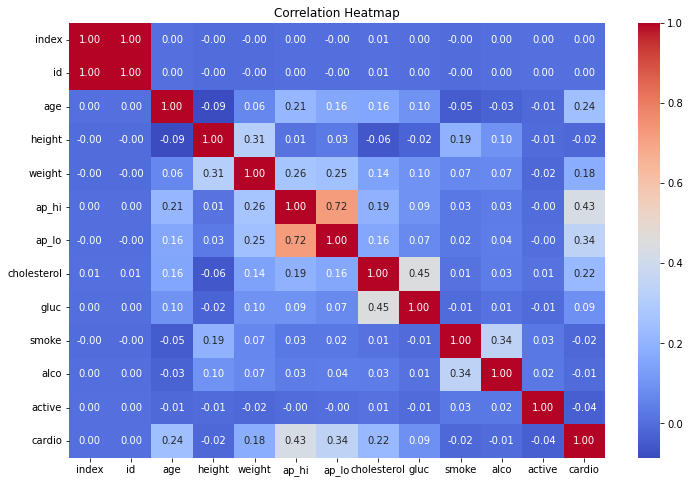

In [46]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler


feature_cols = ['index', 'id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(merged_df)

rf = RandomForestClassifier(featuresCol="features", labelCol="cardio")
model = rf.fit(assembled_data)

importances = model.featureImportances.toArray()

importances_list = [(feature, float(importance)) for feature, importance in zip(feature_cols, importances)]
importance_df = spark.createDataFrame(importances_list, ["Feature", "Importance"])

importance_df = importance_df.orderBy("Importance", ascending=False)

from pyspark.sql.functions import round

importance_df = importance_df.withColumn("Importance", round(importance_df["Importance"], 2))
importance_df.show()

import matplotlib.pyplot as plt

# 获取特征名称和重要性值
feature_names = importance_df.select("Feature").rdd.flatMap(lambda x: x).collect()
importance_values = importance_df.select("Importance").rdd.flatMap(lambda x: x).collect()

# 创建柱状图
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), importance_values, align="center")
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Importance")
plt.title("Feature Importance")

# 显示图表
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# 计算特征之间的相关性矩阵
correlation_matrix = merged_df.select(feature_cols).toPandas().corr()

# 创建一个热图
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



In [4]:
merged_df.describe().toPandas()

summary                 id               index                 age  \
0   count              68056               68056               68056   
1    mean  49961.38948806865   34991.75198366051  19467.796329493358   
2  stddev  28838.84055511243  20198.679156291822  2466.8985187743706   
3     min                  0                   0               10798   
4     max              99999               69999               23713   

               gender              height              weight  \
0               68056               68056               68056   
1  1.3482132361584578  164.41048548254378   73.72453273774539   
2  0.4764075075852865   7.825610733050222  13.423933068620316   
3                   1                 130                30.0   
4                   2                 207               120.0   

                ap_hi              ap_lo         cholesterol  \
0               68056              68056               68056   
1  126.59862466204302  81.28977606676854  1.3629657928764547   
2  16.517518537922864  9.398565292233743  0.6778290292171032   
3                  90                 40                   1   
4                 220                140                   3   

                 gluc                smoke                 alco  \
0               68056                68056                68056   
1  1.2239773128012226  0.08756024450452568  0.05310332667215235   
2  0.5698690836303668   0.2826563674162662  0.22424116979742773   
3                   1                    0                    0   
4                   3                    1                    1   

                active              cardio  
0                68056               68056  
1   0.8037057717174092  0.4936228987892324  
2  0.39719657902829786  0.4999630041132576  
3                    0                   0  
4                    1                   1

In [47]:
from pyspark.sql.functions import col, round

# Calculate BMI
merged_df = merged_df.withColumn("bmi", col("weight") / ((col("height") / 100) ** 2))

# Round BMI to 2 decimal places
merged_df = merged_df.withColumn("bmi", round(col("bmi"), 2))

# Show descriptive statistics for BMI
merged_df.describe("bmi").show()


+-------+------------------+
|summary|               bmi|
+-------+------------------+
|  count|             68056|
|   mean|27.313671829080924|
| stddev| 4.934954139584941|
|    min|             10.73|
|    max|             58.02|
+-------+------------------+



In [48]:
from pyspark.sql.functions import when, col, percentile_approx

# Calculate the median of bmi
median_bmi = merged_df.approxQuantile("bmi", [0.5], 0.0)[0]  # Using approxQuantile to get the median

# Define the conditions for outliers
condition = (col("bmi") < 16) | (col("bmi") > 35)

# Replace outliers with the median value
merged_df = merged_df.withColumn("bmi", when(condition, median_bmi).otherwise(col("bmi")))
merged_df.describe("bmi").show()


+-------+------------------+
|summary|               bmi|
+-------+------------------+
|  count|             68056|
|   mean|26.348999059599507|
| stddev| 3.571605400963905|
|    min|              16.0|
|    max|              35.0|
+-------+------------------+



In [49]:
from pyspark.sql.functions import col, round

# Convert 'age' from days to years and round it to 1 decimal place
merged_df = merged_df.withColumn("age", round(col("age") / 365.0, 1))
merged_df.show()


+---+-----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
| id|index| age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  bmi|
+---+-----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
|  0|    0|50.4|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|21.97|
|  1|    1|55.4|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.93|
|  2|    2|51.7|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.51|
|  3|    3|48.3|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|28.71|
|  4|    4|47.9|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.01|
|  8|    5|60.0|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|29.38|
|  9|    6|60.6|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0| 26.3|
| 12|    7|61.9|    

In [50]:
# Dropping multiple columns in PySpark
merged_df = merged_df.drop('id', 'index', 'height', 'weight')
merged_df.show()

merged_df.describe().toPandas()

+----+------+-----+-----+-----------+----+-----+----+------+------+-----+
| age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  bmi|
+----+------+-----+-----+-----------+----+-----+----+------+------+-----+
|50.4|     2|  110|   80|          1|   1|    0|   0|     1|     0|21.97|
|55.4|     1|  140|   90|          3|   1|    0|   0|     1|     1|34.93|
|51.7|     1|  130|   70|          3|   1|    0|   0|     0|     1|23.51|
|48.3|     2|  150|  100|          1|   1|    0|   0|     1|     1|28.71|
|47.9|     1|  100|   60|          1|   1|    0|   0|     0|     0|23.01|
|60.0|     1|  120|   80|          2|   2|    0|   0|     0|     0|29.38|
|60.6|     1|  130|   80|          3|   1|    0|   0|     1|     0| 26.3|
|61.9|     2|  130|   90|          3|   3|    0|   0|     1|     1|29.98|
|48.4|     1|  110|   70|          1|   1|    0|   0|     1|     0|28.44|
|54.3|     1|  110|   60|          1|   1|    0|   0|     0|     0|25.28|
|61.7|     1|  120|   80|          1| 

summary                age              gender               ap_hi  \
0   count              68056               68056               68056   
1    mean  53.33656694486877  1.3482132361584578  126.59862466204302   
2  stddev  6.758578870962563  0.4764075075852865  16.517518537922864   
3     min               29.6                   1                  90   
4     max               65.0                   2                 220   

               ap_lo         cholesterol                gluc  \
0              68056               68056               68056   
1  81.28977606676854  1.3629657928764547  1.2239773128012226   
2  9.398565292233743  0.6778290292171032  0.5698690836303668   
3                 40                   1                   1   
4                140                   3                   3   

                 smoke                 alco               active  \
0                68056                68056                68056   
1  0.08756024450452568  0.05310332667215235   0.8037057717174092   
2   0.2826563674162662  0.22424116979742773  0.39719657902829786   
3                    0                    0                    0   
4                    1                    1                    1   

               cardio                 bmi  
0               68056               68056  
1  0.4936228987892324  26.348999059599507  
2  0.4999630041132576   3.571605400963905  
3                   0                16.0  
4                   1                35.0

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.sql import DataFrame
def balance_features(df, binary_features, multiclass_features, binary_class_features):
    balanced_df = df

    # 'active', 'smoke', 'alco'
    for feature in binary_features:
        high_count = df.filter(col(feature) == 0).count()
        low_values = df.filter(col(feature) == 1)
        low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
        balanced_df = df.filter(col(feature) == 0).union(low_values_upsampled)

    # 'gluc', 'cholesterol'
    for feature in multiclass_features:
        feature_categories = [row[feature] for row in df.select(feature).distinct().collect()]
        for category in feature_categories:
            high_count = df.filter(col(feature) != category).count()
            low_values = df.filter(col(feature) == category)
            low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
            balanced_df = df.filter(col(feature) != category).union(low_values_upsampled)

    # 'gender'
    for feature in binary_class_features:
        high_count = df.filter(col(feature) == 1).count()
        low_values = df.filter(col(feature) == 2)
        low_values_upsampled = low_values.sample(True, high_count / low_values.count(), seed=42)
        balanced_df = df.filter(col(feature) == 1).union(low_values_upsampled)

    return balanced_df

# Create a Spark DataFrame from your original data source
# e.g., merged_df = spark.read.csv("path_to_your_data.csv", header=True, inferSchema=True)

binary_features = ['active', 'smoke', 'alco']
multiclass_features = ['gluc', 'cholesterol']
binary_class_features = ['gender']

balanced_df = balance_features(merged_df, binary_features, multiclass_features, binary_class_features)




In [52]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Balance 'cardio'
cardio_0_count = balanced_df.filter(col('cardio') == 0).count()
cardio_1_values = balanced_df.filter(col('cardio') == 1)
cardio_1_upsampled = cardio_1_values.sample(True, cardio_0_count / cardio_1_values.count(), seed=42)
balanced_df = balanced_df.filter(col('cardio') == 0).union(cardio_1_upsampled)

# Check counts for visualization
cardio_counts = balanced_df.groupby('cardio').agg(count('cardio').alias('count')).collect()

# Using matplotlib to plot
labels = [row['cardio'] for row in cardio_counts]
sizes = [row['count'] for row in cardio_counts]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Balanced Cardio Counts')
plt.show()


In [53]:
balanced_df.describe().toPandas()

summary                age               gender               ap_hi  \
0   count              89134                89134               89134   
1    mean  53.32032782103335   1.4972849866493145  126.98749074427266   
2  stddev    6.8057299794781  0.49999543339627717  16.510607156574192   
3     min               29.6                    1                  90   
4     max               65.0                    2                 220   

               ap_lo         cholesterol                gluc  \
0              89134               89134               89134   
1  81.51791684430184  1.3563511118091862   1.222137455965176   
2  9.359611881119623   0.673760567001296  0.5682491513990103   
3                 40                   1                   1   
4                140                   3                   3   

                 smoke                 alco               active  \
0                89134                89134                89134   
1  0.12017860748984675   0.0656988354612157   0.8032176273924653   
2  0.32517210221756665  0.24775630595834697  0.39756866543166625   
3                    0                    0                    0   
4                    1                    1                    1   

                cardio                 bmi  
0                89134               89134  
1  0.49984293311194383  26.294938743913452  
2   0.5000027801193122   3.544348837773566  
3                    0                16.0  
4                    1                35.0

Great work! At this stage, we're pretty much done with understanding DataFrames. You can now move on to applying an algorithm. We recommend going through linear regression, then logistic regression and finishing off with tree methods. It's best to start with the documentation example before moving to the advanced example. 

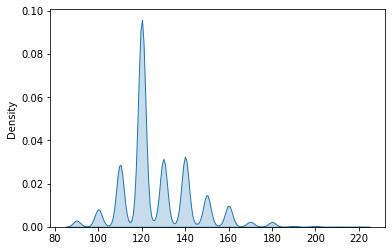

In [54]:

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# Assuming 'balanced_df' is your DataFrame

def plot_kde(df, column_name):
    sampled_data = df.select(column_name).rdd.map(lambda row: row[0]).collect()
    sns.kdeplot(sampled_data, shade=True)
    plt.show()

# Plot KDE plots
plot_kde(balanced_df, 'age')
plot_kde(balanced_df, 'bmi')
plot_kde(balanced_df, 'ap_lo')
plot_kde(balanced_df, 'ap_hi')

# Calculate skewness
def calculate_skew(df, column_name):
    sampled_data = df.select(column_name).rdd.map(lambda row: row[0]).collect()
    return skew(sampled_data)

skew_age = calculate_skew(balanced_df, 'age')
skew_bmi = calculate_skew(balanced_df, 'bmi')
skew_ap_lo = calculate_skew(balanced_df, 'ap_lo')
skew_ap_hi = calculate_skew(balanced_df, 'ap_hi')

In [55]:
print("Age Skewness:", skew_age)
print("BMI Skewness:", skew_bmi)
print("ap_lo Skewness:", skew_ap_lo)
print("ap_hi Skewness:", skew_ap_hi)

Age Skewness: -0.29560255600382285
BMI Skewness: 0.2917896901688652
ap_lo Skewness: 0.38041770745935255
ap_hi Skewness: 0.9591071075674875


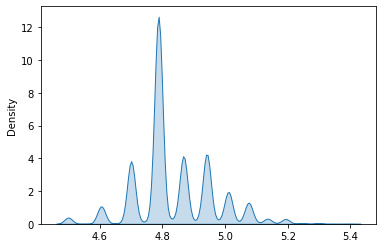

ap_hi Skewness (after transformation): 0.4720612429213762


In [56]:
balanced_df = balanced_df.withColumn('ap_hi', F.log('ap_hi'))
plot_kde(balanced_df, 'ap_hi')
skew_ap_hi_after = calculate_skew(balanced_df, 'ap_hi')
print("ap_hi Skewness (after transformation):", skew_ap_hi_after)

In [57]:
print("Age Skewness:", skew_age)
print("BMI Skewness:", skew_bmi)
print("ap_lo Skewness:", skew_ap_lo)
print("ap_hi Skewness:", skew_ap_hi_after)

Age Skewness: -0.29560255600382285
BMI Skewness: 0.2917896901688652
ap_lo Skewness: 0.38041770745935255
ap_hi Skewness: 0.4720612429213762


In [58]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_columns = ['bmi', 'ap_lo', 'ap_hi']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Decision Tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="cardio",minInstancesPerNode=8)
model = tree_model.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

tree_string = model.toDebugString
tree_depth = tree_string.count('\n') - 1
print(f'The actual depth of the tree is: {tree_depth}')


# Confusion matrix (assuming binary classification 0 and 1)
tp = predictions.filter("cardio = 1 and prediction = 1").count()
tn = predictions.filter("cardio = 0 and prediction = 0").count()
fp = predictions.filter("cardio = 0 and prediction = 1").count()
fn = predictions.filter("cardio = 1 and prediction = 0").count()

# Display confusion matrix (using matplotlib and seaborn for visualization)
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()






Accuracy: 0.7126587005227782
Weighted Precision: 0.7191872340290995
Weighted Recall: 0.7126587005227782
F1 Score: 0.7104038787585172
The actual depth of the tree is: 28


In [59]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Convert feature columns to a single vector column
feature_columns = ['active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)  

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="cardio")
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.6248206057859355
Weighted Precision: 0.6249649844445853
Weighted Recall: 0.6248206057859355
F1 Score: 0.6247122083252179


Accuracy: 0.6259839568183522
Weighted Precision: 0.628541250082389
Weighted Recall: 0.6259839568183523
F1 Score: 0.6237919115110997
The actual depth of the tree is: 43


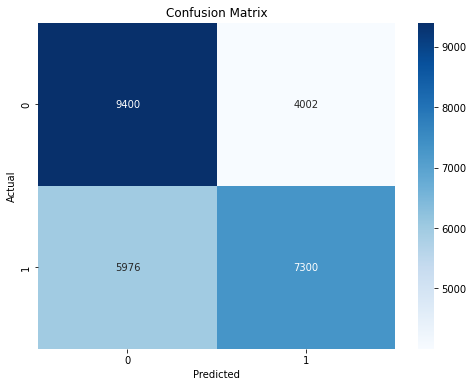

In [60]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_columns = ['active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Decision Tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="cardio",minInstancesPerNode=8)
model = tree_model.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

tree_string = model.toDebugString
tree_depth = tree_string.count('\n') - 1
print(f'The actual depth of the tree is: {tree_depth}')


# Confusion matrix (assuming binary classification 0 and 1)
tp = predictions.filter("cardio = 1 and prediction = 1").count()
tn = predictions.filter("cardio = 0 and prediction = 0").count()
fp = predictions.filter("cardio = 0 and prediction = 1").count()
fn = predictions.filter("cardio = 1 and prediction = 0").count()

# Display confusion matrix (using matplotlib and seaborn for visualization)
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.7286810102899907
Weighted Precision: 0.7301953066846517
Weighted Recall: 0.7286810102899907
F1 Score: 0.7280685953078762
The actual depth of the tree is: 43


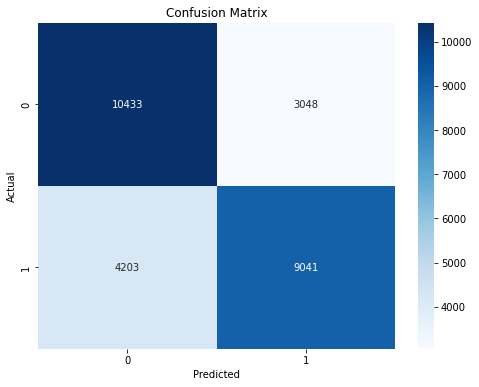

True Negatives (TN): 10433
False Positives (FP): 3048
False Negatives (FN): 4203
True Positives (TP): 9041
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a5a1465c03e3, depth=5, numNodes=29, numClasses=2, numFeatures=10
  If (ap_hi <= 4.8597823571875995)
   If (age <= 55.349999999999994)
    If (cholesterol <= 1.5)
     Predict: 0.0
    Else (cholesterol > 1.5)
     If (cholesterol <= 2.5)
      Predict: 0.0
     Else (cholesterol > 2.5)
      If (gluc <= 2.5)
       Predict: 1.0
      Else (gluc > 2.5)
       Predict: 0.0
   Else (age > 55.349999999999994)
    If (cholesterol <= 2.5)
     If (active <= 0.5)
      If (ap_hi <= 4.7790881836238555)
       Predict: 0.0
      Else (ap_hi > 4.7790881836238555)
       Predict: 1.0
     Else (active > 0.5)
      Predict: 0.0
    Else (cholesterol > 2.5)
     Predict: 1.0
  Else (ap_hi > 4.8597823571875995)
   If (ap_hi <= 4.934448053883255)
    If (cholesterol <= 2.5)
     If (smoke <= 0.5)
      Predict: 1.0
     Else (smoke > 0.

23/10/09 10:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
23/10/09 10:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
23/10/09 10:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1385.1 KiB
23/10/09 10:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
23/10/09 10:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1385.1 KiB
23/10/09 10:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1645.4 KiB
23/10/09 10:29:14 WARN DAGScheduler: Broadcasting large task binary with size 1050.9 KiB
23/10/09 10:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
23/10/09 10:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1385.1 KiB
23/10/09 10:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1645.4 KiB
23/10/09 10:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1916.0 KiB
23/10/09 10:29:22 WAR

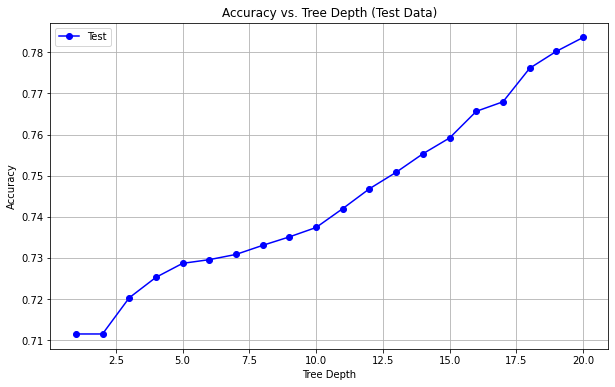

In [65]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_columns = ['bmi', 'ap_lo', 'ap_hi','active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Decision Tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="cardio")
model = tree_model.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

tree_string = model.toDebugString
tree_depth = tree_string.count('\n') - 1
print(f'The actual depth of the tree is: {tree_depth}')


# Confusion matrix (assuming binary classification 0 and 1)
tp = predictions.filter("cardio = 1 and prediction = 1").count()
tn = predictions.filter("cardio = 0 and prediction = 0").count()
fp = predictions.filter("cardio = 0 and prediction = 1").count()
fn = predictions.filter("cardio = 1 and prediction = 0").count()

# Display confusion matrix (using matplotlib and seaborn for visualization)
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

def replace_feature_indices_with_names(tree_string, feature_columns):
    for index, feature_name in enumerate(feature_columns):
        tree_string = tree_string.replace(f"feature {index}", feature_name)
    return tree_string

tree_string = model.toDebugString
modified_tree_string = replace_feature_indices_with_names(tree_string, feature_columns)
print(modified_tree_string)





Accuracy: 0.7312991005351247
Weighted Precision: 0.7344036714673886
Weighted Recall: 0.7312991005351246
F1 Score: 0.730310403797962
The actual depth of the tree is: 52


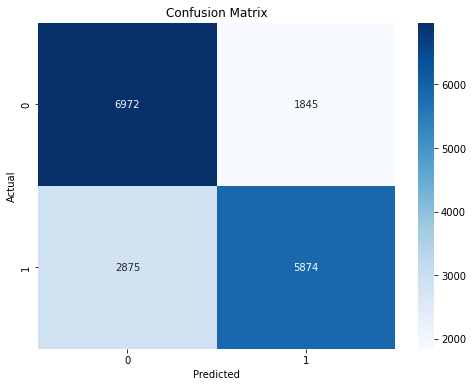

True Negatives (TN): 6972
False Positives (FP): 1845
False Negatives (FN): 2875
True Positives (TP): 5874


In [62]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_columns = ['bmi', 'ap_lo', 'ap_hi','active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)

# Split the data
(train_data, test_data) = data.randomSplit([0.8, 0.2])

# Create and fit the Decision Tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="cardio")
model = tree_model.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"F1 Score: {f1}")

tree_string = model.toDebugString
tree_depth = tree_string.count('\n') - 1
print(f'The actual depth of the tree is: {tree_depth}')


# Confusion matrix (assuming binary classification 0 and 1)
tp = predictions.filter("cardio = 1 and prediction = 1").count()
tn = predictions.filter("cardio = 0 and prediction = 0").count()
fp = predictions.filter("cardio = 0 and prediction = 1").count()
fn = predictions.filter("cardio = 1 and prediction = 0").count()

# Display confusion matrix (using matplotlib and seaborn for visualization)
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


In [63]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Convert feature columns to a single vector column
feature_columns = ['bmi', 'ap_lo', 'ap_hi']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)  

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="cardio")
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7131061402191863
Weighted Precision: 0.7185748875579414
Weighted Recall: 0.7131061402191863
F1 Score: 0.7111158811410581


Accuracy: 0.7271945566023628
Weighted Precision: 0.7286041533436978
Weighted Recall: 0.7271945566023628
F1 Score: 0.7266422526002931


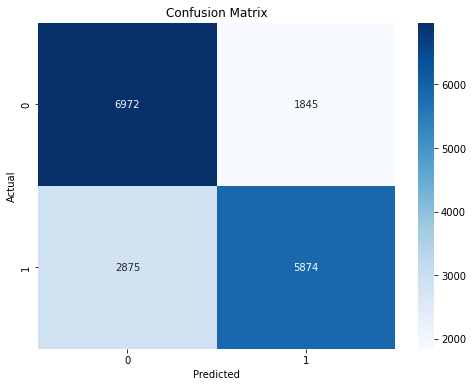

Coefficients:
bmi: 0.037563369487876364
ap_lo: 0.012478632303526123
ap_hi: 7.35622956072989
active: -0.2667600174071865
smoke: -0.18036446566958417
alco: -0.10857033812738962
gluc: -0.14929814710753314
cholesterol: 0.5041127684439635
gender: 0.0038024193675726776
age: 0.05101761432129543

Intercept: -40.519720991826055


In [64]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Convert feature columns to a single vector column
feature_columns = ['bmi', 'ap_lo', 'ap_hi','active','smoke','alco','gluc','cholesterol','gender','age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(balanced_df)  

# Split the data
(train_data, test_data) = data.randomSplit([0.7, 0.3])

# Create and fit the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="cardio")
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = [[tn, fp], [fn, tp]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


print("Coefficients:")
for feature, coeff in zip(feature_columns, lr_model.coefficients):
    print(f"{feature}: {coeff}")
print("\nIntercept:", lr_model.intercept)





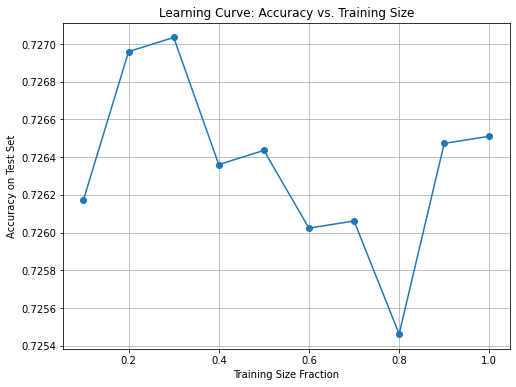

In [66]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def train_and_evaluate(train_subset):
    lr = LogisticRegression(featuresCol="features", labelCol="cardio")
    lr_model = lr.fit(train_subset)
    predictions = lr_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="cardio", predictionCol="prediction", metricName="accuracy"
    )
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    return accuracy

sample_fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
accuracies = []

for fraction in sample_fractions:
    subset = train_data.sample(withReplacement=False, fraction=fraction)
    acc = train_and_evaluate(subset)
    accuracies.append(acc)

plt.figure(figsize=(8, 6))
plt.plot(sample_fractions, accuracies, '-o')
plt.title('Learning Curve: Accuracy vs. Training Size')
plt.xlabel('Training Size Fraction')
plt.ylabel('Accuracy on Test Set')
plt.grid(True)
plt.show()

